## Convolutional Neural Networks with PSD features, theta and alpha bands only


In [201]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import pywt 


%matplotlib inline 
# %matplotlib qt


In [6]:
#Importing raw data files 

#.csv path
csvpath = "C:/Users/Wu Di/Documents/EEG-analysis/200108-Readings-csv/thinking-counting-switching.csv"

#Read .csv files
cols_to_use = list(range(4, 36))

#Raw dataframes - each channel is a column
raw_df = pd.read_csv(csvpath, header=None, usecols=cols_to_use)

#Split into thinking and counting data frames
think_index_list = []
count_index_list = []

for i in range(6):
    if i%2==0:
        think_index_list+=(list(range(1280*i,1280*(i+1))))
    else:
        count_index_list+=(list(range(1280*i,1280*(i+1))))


# for i in range(len(all_bands_list)):
#     df = all_bands_list[i].iloc[0:1280*6]
df = raw_df.iloc[0:1280*6]
df_list = np.vsplit(df,6)
think_df = pd.DataFrame(np.vstack((df_list[0],df_list[2],df_list[4])))
count_df = pd.DataFrame(np.vstack((df_list[1],df_list[3],df_list[5])))

print(think_df.shape)
print(count_df.shape)

(3840, 32)
(3840, 32)


In [83]:
raw_df.shape

(7967, 32)

In [15]:
#Splits a single dataframe into list of equally sized arrays
#Each element in list is nx32 array, where n= sample length 
def split_df(df,fs,sample_t,check=False):
    rows,_ = df.shape #get no. of rows
    sample_len = int(sample_t*fs) #find no. of recorded samples required for each sample time length
    Ns = int(rows/sample_len) #find total no. of samples
    df_cut = df.iloc[:Ns*sample_len] #truncate dataframe to exact multiple of sample length
    # print(Ns*sample_len)
    # print(Ns)
    df_split_list = np.vsplit(df_cut,Ns) #split dataframe row-wise, returns a list
    
    if check:
        print("Total no. of recorded samples: "+str(rows))
        print("Sample length: "+str(sample_len))
        print("Total no. of samples: "+str(Ns))
        print("Length of df_split_list: "+str(len(df_split_list)))
        
        if all(isinstance(x.shape,tuple) for x in df_split_list):
            print("Shape of each element in df_split_list: "+str(df_split_list[0].shape))
        else:
            print("Shapes are wrong.")
            for x in df_split_list:
                print(x.shape)
    return df_split_list,Ns
#Apply split_df() function to list of dataframes, reshape dataframe such that each element is an array 
#for the appropriate sample time length 
def split_bands_list(bands_list,fs,sample_t,check=False,checkSD=False):
    df_list_rFE = [0]*len(bands_list) #dataframes list ready for feature extraction 
    for df_no in range(len(bands_list)):
        df_split_list,Ns = split_df(bands_list[df_no],fs,sample_t,check=checkSD)
        list_of_series = [0]*Ns
        for i in range(len(df_split_list)):
            #New dataframe will have shape Nsx32, each element is a 1xsample_len array 
            new_row = [0]*32 
            #Each df_split_list[i] is a dataframe
            for j in range(len(df_split_list[i].columns)):
                new_row[j] = df_split_list[i].iloc[:,j].values 
            list_of_series[i] = new_row
        df_list_rFE[df_no] = pd.DataFrame(list_of_series)
    if check:
        print("Length of bands_list: "+str(len(bands_list)))
        print("Length of df_list_rFE: "+str(len(df_list_rFE)))
        if (all(isinstance(x.shape,tuple) for x in df_list_rFE)) and (Ns==len(df_list_rFE[0].index)):
            print("Shape of each dataframe in df_list_rFE: "+str(df_list_rFE[0].shape))
    return df_list_rFE

In [8]:
#Split filtered dataframes into samples
fs = 128 #sampling freq
sample_t_list = [0.05,0.1] #sample time lengths in seconds

In [20]:
T_005_splits_df = split_bands_list([think_df],fs,sample_t_list[0],check=False,checkSD=True)[0]
T_01_splits_df  = split_bands_list([think_df],fs,sample_t_list[1],check=False,checkSD=True)[0]

Total no. of recorded samples: 3840
Sample length: 6
Total no. of samples: 640
Length of df_split_list: 640
Shape of each element in df_split_list: (6, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)


In [195]:
C_005_splits_df = split_bands_list([count_df],fs,sample_t_list[0],check=False,checkSD=True)[0]
C_01_splits_df  = split_bands_list([count_df],fs,sample_t_list[1],check=False,checkSD=True)[0]

Total no. of recorded samples: 3840
Sample length: 6
Total no. of samples: 640
Length of df_split_list: 640
Shape of each element in df_split_list: (6, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)


In [186]:
#Create spectrograms for each channel, sum, and normalize
def generate_spectrograms(splits_df):
    samples, columns = splits_df.shape
    spectrograms = [0]*samples
    nperseg = int(len(splits_df.iloc[0,0])/2)
    for i in range(samples):
        sc = StandardScaler()
        channels_spectrograms = []
        for j in range(columns):
            f,t,Sxx = signal.spectrogram(np.array(splits_df.iloc[i,j]),128,nperseg=nperseg)
            channels_spectrograms.append(Sxx)
        channels_spectrograms = np.asarray(channels_spectrograms)
        _,sh1,sh2 = channels_spectrograms.shape
        concat_spectrogram = np.sum(channels_spectrograms,axis=0).reshape((sh1,sh2))
        sc_spectrogram = sc.fit_transform(concat_spectrogram)
        spectrograms[i] = sc_spectrogram
    return np.asarray(spectrograms)

T_spectrograms005 = generate_spectrograms(T_005_splits_df)
T_spectrograms01 = generate_spectrograms(T_01_splits_df)


In [189]:
T_spectrograms005 = generate_spectrograms(T_005_splits_df)
T_spectrograms01 = generate_spectrograms(T_01_splits_df)
print(T_spectrograms005.shape)
print(T_spectrograms01.shape)

(640, 2, 2)
(320, 4, 2)


In [196]:
C_spectrograms005 = generate_spectrograms(C_005_splits_df)
C_spectrograms01 = generate_spectrograms(C_01_splits_df)
print(C_spectrograms005.shape)
print(C_spectrograms01.shape)

(640, 2, 2)
(320, 4, 2)


In [222]:
T_spectrograms005 = T_spectrograms005.reshape(640,2,2,1)
T_spectrograms01 = T_spectrograms01.reshape(320,4,2,1)
C_spectrograms005 = C_spectrograms005.reshape(640,2,2,1)
C_spectrograms01 = C_spectrograms01.reshape(320,4,2,1)

In [225]:
dataset005 = np.vstack((T_spectrograms005,C_spectrograms005))
dataset01 = np.vstack((T_spectrograms01,C_spectrograms01))
labels005 = np.array([0]*640+[1]*640)
labels01 = np.array([0]*320+[1]*320)

In [289]:
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(2, 2 ,1)))
model.add(layers.MaxPooling2D((1, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics = ['accuracy'])

In [290]:
X,y = dataset005,labels005.astype(np.float32)
sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
for train_index, test_index in sss.split(X,y):
            X_train, X_test = X[train_index],X[test_index]
            y_train, y_test = y[train_index],y[test_index]

In [234]:
X.shape
print(y.shape)

(1280,)


In [291]:
model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test),verbose=0)

In [292]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)


8/8 - 0s - loss: 0.6943 - accuracy: 0.4492


In [304]:
X,y = dataset01,labels01.astype(np.float32)
sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
for train_index, test_index in sss.split(X,y):
            X_train, X_test = X[train_index],X[test_index]
            y_train, y_test = y[train_index],y[test_index]


In [317]:
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(4,2,1),padding='same'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Conv2D(64, (2, 2), activation='relu',padding='same'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics = ['accuracy'])

In [318]:
model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),verbose=0)
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.6987 - accuracy: 0.4922


In [211]:
CNN_model = models.Sequential()
CNN_model.add(layers.Conv2D(32,kernel_size=(2, 2), strides=(1, 1),
                 activation='relu',
                 input_shape=(32,2,2)))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Dense(1000, activation='relu'))
CNN_model.add(layers.Dense(2, activation='sigmoid'))
CNN_model.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics = ['accuracy'])

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_5/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](conv2d_7/Identity)' with input shapes: [?,31,1,32].

In [185]:
channels_spectrograms=[]
for i in range(32):
    f,t,Sxx =  signal.spectrogram(np.array(T_005_splits_df.iloc[0,i]),128,nperseg=3)
    # plt.pcolormesh(t, f, Sxx)
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.show()
    channels_spectrograms.append(Sxx)
channels_spectrograms = np.asarray(channels_spectrograms)
print(channels_spectrograms.shape)

channels_spectrograms=[]
for i in range(32):
    f,t,Sxx =  signal.spectrogram(np.array(T_01_splits_df.iloc[0,i]),128,nperseg=6)
    # plt.pcolormesh(t, f, Sxx)
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.show()
    channels_spectrograms.append(Sxx)
channels_spectrograms = np.asarray(channels_spectrograms)
print(channels_spectrograms.shape)
# channels = []
# for i in range(32):
#     a = T_005_splits_df.iloc[0,i]
#     channels.append(a)
# channels = np.array(channels).reshape(32,-1)
# channels_sum = np.sum(channels,axis=0)
# f,t,Sxx = signal.spectrogram(channels_sum,128,nperseg=2)
# print(f)
# print(t)
# print(Sxx)

(32, 2, 2)
(32, 4, 2)


In [144]:
T_spectrograms005.shape

(640, 4, 1)

In [145]:
T_spectrograms01.shape

(320, 7, 1)

In [113]:
#DWT on each channel
def dwt_df(splits_df,wavelet='db4',mode='zero',levels=4):
    dwt_df = splits_df.applymap(lambda x: pywt.wavedec(x,wavelet,mode,levels))
    # dwt_df = dwt_df.applymap(lambda x: np.array([item for sublist in x for item in sublist]))
    return dwt_df

T_005_dwt_df = dwt_df(T_005_splits_df)

# dwt_df(T_005_splits_df)
# pywt.wavedec(T_005_splits_df[0],'db4','zero',4)
# T_005_splits_df[0]
# dwt_df_list[i] = df.applymap(lambda x: pywt.wavedec(x,'db4',level=4))
# dwt_df_list[i] = dwt_df_list[i].applymap(lambda x: np.array([item for sublist in x for item in sublist])

In [115]:
#Create spectrogram as 2D array
numLevels = len(T_005_dwt_df.iloc[0,0][0])-1
print(numLevels)

5


In [151]:
total_spectrograms = []
for i in range(32):
    f,t,Sxx =  signal.spectrogram(np.array(T_005_dwt_df.iloc[0,i]),128)
    total_spectrograms.append(Sxx)
total_spectrograms = np.asarray(total_spectrograms)

In [155]:
_,s1,s2,_=total_spectrograms.shape
total_spectrograms.shape

(32, 5, 4, 1)

In [129]:
concat_spectrograms = np.sum(total_spectrograms,axis=0).reshape((5,4))
concat_spectrograms.shape

(5, 4)

In [130]:
print(concat_spectrograms)

[[2.04461332e+02 1.60798184e+04 5.41375120e+03 1.16619682e+03]
 [2.71978775e+02 1.90659508e+04 1.92107547e+04 1.97189231e+04]
 [1.05297152e+01 5.32982764e+03 8.02104923e+03 4.77390269e+03]
 [7.02050321e+00 4.44503666e+04 7.45672953e+04 5.29560929e+04]
 [3.63322112e+04 2.11436217e+03 3.08639621e+03 4.09245751e+03]]


In [132]:
sc = StandardScaler()
sc.fit_transform(concat_spectrograms)

array([[-0.49439698, -0.08892285, -0.62042191, -0.79589607],
       [-0.48973542,  0.11099137, -0.10618949,  0.16447705],
       [-0.50778647, -0.8086083 , -0.52324449, -0.60914488],
       [-0.50802876,  1.81041559,  1.95702137,  1.88498347],
       [ 1.99994763, -1.02387581, -0.70716548, -0.64441957]])

In [121]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

ValueError: too many values to unpack (expected 2)

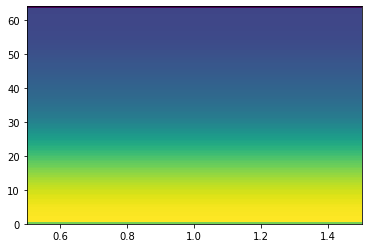

In [59]:
a= (T_005_splits_df.iloc[0,0])
f,t,Sxx = signal.spectrogram(raw_df.iloc[:,0],128)
# print(f)
# print(t)
# print(Sxx)
spec,freqs,t,im =plt.specgram(a,Fs=128)

7967


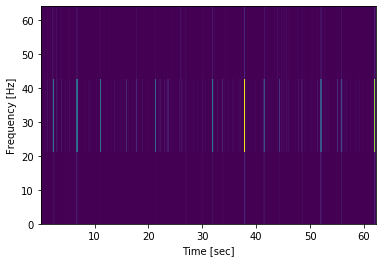

In [94]:
# a= (T_005_splits_df.iloc[0,0])
a = raw_df.iloc[:,1]
print(len(a))
f,t,Sxx = signal.spectrogram(a,128,nperseg=6)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

4
1327
4


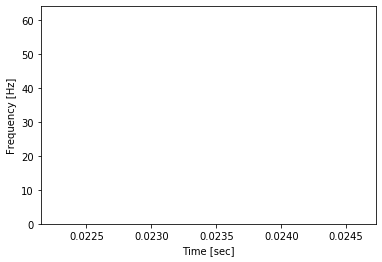

In [97]:
print(len(f))
print(len(t))
print(len(Sxx))
plt.pcolormesh(t[:1], f, [Sxx[0][:1],Sxx[1][:1],Sxx[2][:1],Sxx[3][:1]])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show() 

In [95]:
print((f))
print((t[:2]))
print(len(Sxx[0]))

[ 0.         21.33333333 42.66666667 64.        ]
[0.0234375 0.0703125]
1327


In [13]:
C_005_splits_list   = split_df(count_df,fs,sample_t_list[0],check=True)
C_01_splits_list   = split_df(count_df,fs,sample_t_list[1],check=True)

Total no. of recorded samples: 3840
Sample length: 6
Total no. of samples: 640
Length of df_split_list: 640
Shape of each element in df_split_list: (6, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)


In [14]:
print(len(C_01_splits_list))

320
